In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

from astroplan.plots import plot_airmass
from matplotlib import pyplot as plt
%matplotlib inline

from astroplan import Observer

from pocs.scheduler.dispatch import Scheduler
from pocs.scheduler.constraint import Duration, MoonAvoidance
from pocs.utils.config import load_config
from pocs.utils import listify

config = load_config()

In [3]:
# Get a location
loc = config['location']
location = EarthLocation(lon=loc['longitude'], lat=loc['latitude'], height=loc['elevation'])

# Get an observer at the location
observer = Observer(location=location)

# Get the night hours (you can use observer.tonight())
times = observer.tonight(horizon=-18 * u.degree)
start_of_night = times[0]
end_of_night = times[1]
# start_of_night = Time('2016-08-13 10:00:00')
# end_of_night = Time('2016-08-13 16:00:00')

In [4]:
simple_fields_file = config['directories']['targets'] + '/simple.yaml'

# Simple constraint to maximize duration above a certain altitude
constraints = [MoonAvoidance(), Duration(30 * u.deg)]

# Create a scheduler
scheduler = Scheduler(simple_fields_file, observer, constraints=constraints)

In [5]:
for obs in scheduler.observations.values():
    print(obs)

M44: 120.0 s exposures in blocks of 10, minimum 60, priority 50
M5: 120.0 s exposures in blocks of 10, minimum 60, priority 50
HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
M42: 240.0 s exposures in blocks of 10, minimum 60, priority 25
Tres 3: 120.0 s exposures in blocks of 10, minimum 60, priority 100
KIC 8462852: 60.0 s exposures in blocks of 15, minimum 45, priority 100
HD 189733: 120.0 s exposures in blocks of 10, minimum 60, priority 100


In [6]:
# Get the best observations for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(time=start_of_night, show_all=True)

for b in listify(best):
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: KIC 8462852  Merit: 102.15266634152957
Field: HD 189733    Merit: 102.01214843872178


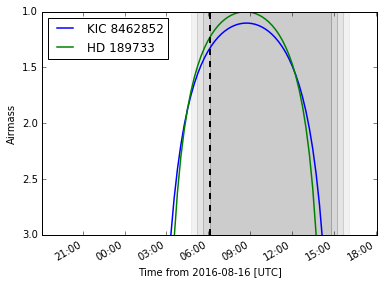

In [7]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, start_of_night, 
             brightness_shading=True)
        
plt.axvline(start_of_night.plot_date, lw=2, ls='--', c='k')    
plt.legend(loc=2)
plt.show()

In [8]:
# Set a later time to start
t2 = end_of_night - 3 * u.hour

# Get the best observation for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=t2)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: Wasp 33      Merit: 102.51725826782425
Field: HD 209458    Merit: 102.20799653051353
Field: KIC 8462852  Merit: 101.80098337820013


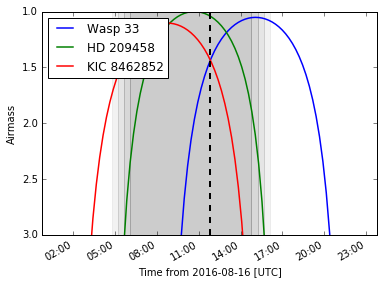

In [9]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, t2, 
             brightness_shading=True)
plt.axvline(t2.plot_date, lw=2, ls='--', c='k')
plt.legend(loc=2)
plt.show()

## Entire Night Simulation

Now let's simulate going through the whole evening

In [10]:
# Start at the beginning of the night
next_time = start_of_night
print("Start of night at {}".format(start_of_night))

# Reset scheduler
# Create a scheduler
scheduler = Scheduler(simple_fields_file, observer, constraints=constraints)

while (next_time < end_of_night):    
    # Only get new target if we have met min_nexp for observation
    if (scheduler.current_observation is None) or \
        (scheduler.current_observation.current_exp >= scheduler.current_observation.min_nexp):
        
        print("Getting new observation at {}".format(next_time))
        new_obs = scheduler.get_observation(time=next_time)
        
    if scheduler.current_observation is not None:

        if (scheduler.current_observation.current_exp < scheduler.current_observation.min_nexp):
            obs_duration = scheduler.current_observation.minimum_duration

            # Fake the exposure count
            scheduler.current_observation.current_exp = scheduler.current_observation.min_nexp
        else:
            obs_duration = scheduler.current_observation.set_duration
            # Fake the exposure count
            scheduler.current_observation.current_exp += scheduler.current_observation.exp_set_size

        print("\tWill observe {} with merit of {:0.5f} for {}".format(
                    scheduler.current_observation.name, 
                    scheduler.current_observation.merit, 
                    obs_duration))
        print("\t{} of {}".format(scheduler.current_observation.current_exp, 
                                  scheduler.current_observation.min_nexp))
                
    next_time = next_time + obs_duration
    
print("End of night at {}".format(end_of_night.isot))

Start of night at 2457617.7540323106
Getting new observation at 2457617.7540323106
	Will observe KIC 8462852 with merit of 102.15267 for 2700.0 s
	45 of 45
Getting new observation at 2457617.7852823106
	Will observe HD 209458 with merit of 102.21491 for 7200.0 s
	60 of 60
Getting new observation at 2457617.868615644
	Will observe KIC 8462852 with merit of 102.06674 for 2700.0 s
	45 of 45
Getting new observation at 2457617.899865644
	Will observe KIC 8462852 with merit of 102.02743 for 900.0 s
	60 of 45
Getting new observation at 2457617.9102823106
	Will observe KIC 8462852 with merit of 102.01167 for 900.0 s
	75 of 45
Getting new observation at 2457617.920698977
	Will observe KIC 8462852 with merit of 101.99423 for 900.0 s
	90 of 45
Getting new observation at 2457617.931115644
	Will observe KIC 8462852 with merit of 101.97485 for 900.0 s
	105 of 45
Getting new observation at 2457617.9415323106
	Will observe KIC 8462852 with merit of 101.95313 for 900.0 s
	120 of 45
Getting new observat

2016-08-17 15:28:37 ganymede panoptes[10684] WARNING No valid observations found


End of night at 2016-08-17T14:47:00.102
